### MACS 30100 
Lerong Wang

In [718]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import norm
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook
%matplotlib inline

### 1 Income Data

### (a) Plot a histogram of percentages of the income.txt data with 30 bins

In [719]:
income = np.loadtxt('incomes.txt')

Text(0,0.5,'Percent of observations')

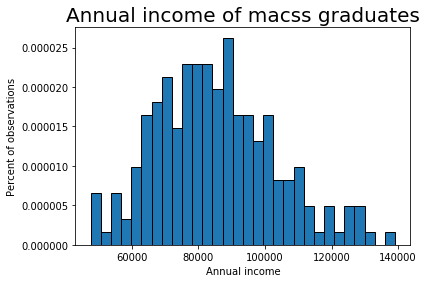

In [720]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual income of macss graduates', fontsize=20)
plt.xlabel('Annual income')
plt.ylabel('Percent of observations')

### (b) Estimate the parameters of the lognormal distribution by generalized method of moments. Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.

In [721]:
def lognorm_pdf(xvals, mu, sigma):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the lognormal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
        
    pdf_vals    = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))))
    
    return pdf_vals

In [722]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, stf_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


def model_moments(mu, sigma):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, std_model
    --------------------------------------------------------------------
    '''
    mean_model = np.exp(mu + sigma ** 2/2)
    var_model = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma**2)
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model


def err_vec(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [723]:
mu_init, sig_init = 11, 0.5   # get the values from ps2
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, W_hat)
results = opt.minimize(criterion, params_init, gmm_args, 
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM, sig_GMM = results.x
print('mu_GMM=', mu_GMM, ' sig_GMM=', sig_GMM)
print("The value of GMM criterion function is", results.fun[0][0])

mu_GMM= 11.3318807729  sig_GMM= 0.208696666481
The value of GMM criterion function is 6.99496827822e-15


In [724]:
mean_data, std_data = data_moments(income)
mean_model, std_model = model_moments(mu_GMM, sig_GMM)
err = err_vec(income, mu_GMM, sig_GMM, False)
print('Mean of data =', mean_data, ', Standard deviation of data =', std_data)
print('Mean of model =', mean_model, ', Standard deviation of model =', std_model)
print('error vector is', err)

Mean of data = 85276.8236063 , Standard deviation of data = 17992.542128
Mean of model = 85276.8176502 , Standard deviation of model = 17992.5413002
error vector is [[ -6.98440504e-08]
 [ -4.60084439e-08]]


The two data moments are quite close to the two model moments at the estimated parameter values

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


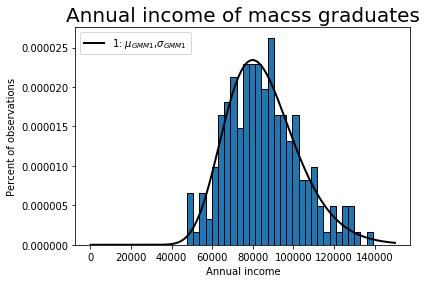

In [725]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual income of macss graduates', fontsize=20)
plt.xlabel('Annual income')
plt.ylabel('Percent of observations')

# Plot the estimated GMM PDF
dist_income = np.linspace(0, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM, sig_GMM),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

### (c) Perform the two-step GMM estimator

In [726]:
err = err_vec(income, mu_GMM, sig_GMM, False)
VCV = np.dot(err, err.T) / income.shape[0]
print('Variance covariance matrix is: \n', VCV)
W_hat2 = lin.pinv(VCV)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print('Optimal weighting matrix is: \n', W_hat2 )

Variance covariance matrix is: 
 [[  2.43909569e-17   1.60670804e-17]
 [  1.60670804e-17   1.05838845e-17]]
Optimal weighting matrix is: 
 [[  1.99396408e+16   1.31348603e+16]
 [  1.31348603e+16   8.65234018e+15]]


In [727]:
mu_init = mu_GMM
sig_init = sig_GMM
params_init = np.array([mu_init, sig_init])
gmm_args = (income, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.3318808111  sig_GMM2= 0.208696676794


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


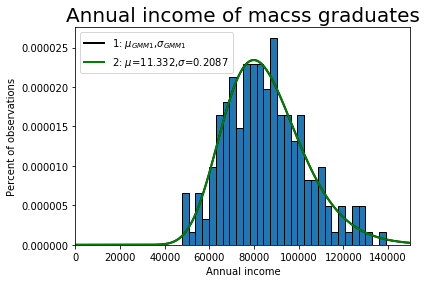

In [728]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual income of macss graduates', fontsize=20)
plt.xlabel('Annual income')
plt.ylabel('Percent of observations')
plt.xlim([0,150000])
# Plot the estimated GMM PDF
dist_income = np.linspace(0, 150000, 1000)
plt.plot(dist_income, lognorm_pdf(dist_pts, mu_GMM, sig_GMM),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

# Plot the GMM2 estimated distribution
plt.plot(dist_income, lognorm_pdf(dist_income, mu_GMM2, sig_GMM2),
         linewidth=2, color='g', label='2: $\mu$=11.332,$\sigma$=0.2087')
plt.legend(loc='upper left')
plt.show()

In [729]:
print('The value of GMM criterion function:', results2.fun)
mean_data, std_data = data_moments(income)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2)
err2 = err_vec(income, mu_GMM2, sig_GMM2, False)
print('Mean of points =', mean_data, ', Standard deviation of points =', std_data)
print('Mean of model =', mean_model2, ', Standard deviation of model =', std_model2)
print('error vector is \n', err2)

The value of GMM criterion function: [[  2.53627630e-05]]
Mean of points = 85276.8236063 , Standard deviation of points = 17992.542128
Mean of model = 85276.8210871 , Standard deviation of model = 17992.5429339
error vector is 
 [[ -2.95405833e-08]
 [  4.47905394e-08]]


The two data moments are quite close to the two model moments at the estimated parameter values.

### (d)

In [730]:
def data_moments4(xvals):     
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >=100000) & (xvals < 150000)].shape[0] /
                  xvals.shape[0])
   

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

def model_moments4(mu, sigma):

    bpct_1_mod = norm.cdf((np.log(75000)-mu)/sigma)
    bpct_2_mod = norm.cdf((np.log(100000)-mu)/sigma) - bpct_1_mod
    bpct_3_mod = 1 - norm.cdf((np.log(100000)-mu)/sigma)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec4(xvals, mu, sigma, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat= \
        data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments4(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion4(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, W = args
    err = err_vec4(xvals, mu, sigma, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [731]:
mu_init = mu_GMM
sig_init = sig_GMM
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (income, W_hat)
results3 = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results3.x
print('mu_GMM3=', mu_GMM3, ' sig_GMM3=', sig_GMM3)
print('The value of the GMM criterion function at the estimated parameter values is', 
      results3.fun[0][0])

mu_GMM3= 11.3356813274  sig_GMM3= 0.210598453879
The value of the GMM criterion function at the estimated parameter values is 2.50233171872e-11


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


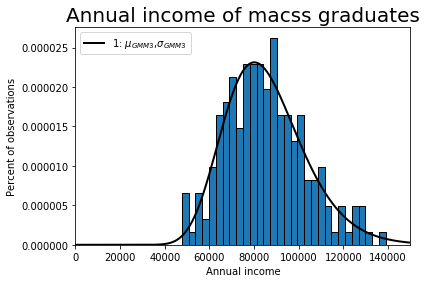

In [732]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual income of macss graduates', fontsize=20)
plt.xlabel('Annual income')
plt.ylabel('Percent of observations')
plt.xlim([0,150000])
# Plot the estimated GMM PDF
dist_income = np.linspace(0, 150000, 1000)
plt.plot(dist_income, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3),
         linewidth=2, color='k', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')

In [733]:
err3 = err_vec4(income, mu_GMM2, sig_GMM2, False)
bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments4(income)
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments4(mu_GMM3, sig_GMM3)
print("error vector is \n", err3)
print('Data moment1(<75000) = ', bpct_1_dat, 
      '\n Data moment2(75000~100000) = ', bpct_2_dat, 
      '\n Data moment3(>100000) = ', bpct_3_dat,
      '\n Model moment1(<75000) = ', bpct_1_mod, 
      '\n Model moment2(75000~100000) =', bpct_2_mod, 
      '\n Model moment3(>100000) = ', bpct_3_mod)

error vector is 
 [[ 1.56219091]
 [ 0.49594954]
 [-3.5831602 ]]
Data moment1(<75000) =  0.3 
 Data moment2(75000~100000) =  0.5 
 Data moment3(>100000) =  0.2 
 Model moment1(<75000) =  0.300000003891 
 Model moment2(75000~100000) = 0.500000005516 
 Model moment3(>100000) =  0.199999990593


The value three data moments and the three model moments at the estimated parameter values are quite close.

### (e) Perform the two-step GMM estimator by using your estimates from part (d)

In [734]:
err3= err_vec4(income, mu_GMM3, sig_GMM3, False)
VCV3 = np.dot(err3, err3.T) / income.shape[0]
print('The variance covariance matrix is:')
print(VCV3)
W_hat3 = lin.pinv(VCV3)  
print('The optimal weighting matrix is:')
print(W_hat3)

The variance covariance matrix is:
[[  8.41278706e-15   7.15471604e-15  -3.05059707e-14]
 [  7.15471604e-15   6.08478037e-15  -2.59440250e-14]
 [ -3.05059707e-14  -2.59440250e-14   1.10619019e-13]]
The optimal weighting matrix is:
[[  5.37415423e+11   4.57048861e+11  -1.94874529e+12]
 [  4.57048861e+11   3.88700534e+11  -1.65732463e+12]
 [ -1.94874529e+12  -1.65732463e+12   7.06642950e+12]]


In [735]:
params_init = np.array([mu_GMM3, sig_GMM3])
gmm_args = (income, W_hat3)
results4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                        method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results4.x
print('mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4)
print('The value of the GMM criterion function at the estimated parameter values is', 
      results4.fun[0][0])

mu_GMM4= 11.3356813285  sig_GMM4= 0.210598456534
The value of the GMM criterion function at the estimated parameter values is 57.1063108448


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in multiply


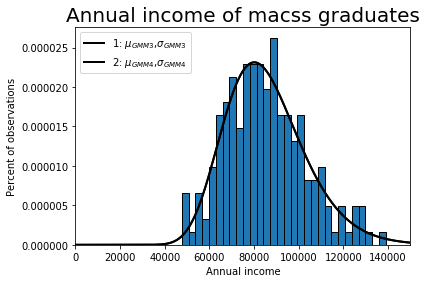

In [736]:
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Annual income of macss graduates', fontsize=20)
plt.xlabel('Annual income')
plt.ylabel('Percent of observations')
plt.xlim([0,150000])
# Plot the estimated GMM PDF
dist_income = np.linspace(0, 150000, 1000)
plt.plot(dist_income, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3),
         linewidth=2, color='k', label='1: $\mu_{GMM3}$,$\sigma_{GMM3}$')
plt.legend(loc='upper left')


plt.plot(dist_income, lognorm_pdf(dist_pts, mu_GMM4, sig_GMM4),
         linewidth=2, color='k', label='2: $\mu_{GMM4}$,$\sigma_{GMM4}$')
plt.legend(loc='upper left')

In [737]:
err4 = err_vec4(income, mu_GMM4, sig_GMM4, False)
bpct_1_dat2, bpct_2_dat2, bpct_3_dat2 = data_moments4(income)
bpct_1_mod2, bpct_2_mod2, bpct_3_mod2 = model_moments4(mu_GMM4, sig_GMM4)
print("error vector is \n", err4)
print('Data moment1(<75000) = ', bpct_1_dat2, 
      '\n Data moment2(75000~100000) = ', bpct_2_dat2, 
      '\n Data moment3(>100000) = ', bpct_3_dat2,
      '\n Model moment1(<75000) = ', bpct_1_mod2, 
      '\n Model moment2(75000~100000) =', bpct_2_mod2, 
      '\n Model moment3(>100000) = ', bpct_3_mod2)

error vector is 
 [[  1.40653876e-06]
 [  1.26191679e-07]
 [ -2.42528733e-06]]
Data moment1(<75000) =  0.3 
 Data moment2(75000~100000) =  0.5 
 Data moment3(>100000) =  0.2 
 Model moment1(<75000) =  0.30000000422 
 Model moment2(75000~100000) = 0.500000000631 
 Model moment3(>100000) =  0.199999995149


Again, the value three data moments and the three model moments at the estimated parameter values are quite close.

### (f) Which of the four estimations from parts (b), (c), (d), and (e) is the data best? Justify your answer.

In [745]:
print(err)
print(err2)
print(err3)
print(err4)

[[ -6.98440504e-08]
 [ -4.60084439e-08]]
[[ -2.95405833e-08]
 [  4.47905394e-08]]
[[  1.29713431e-06]
 [  1.10315732e-06]
 [ -4.70359476e-06]]
[[  1.40653876e-06]
 [  1.26191679e-07]
 [ -2.42528733e-06]]


From the plots, we can see tht the four estimations from (b), (c), (d) and (e) fit the data almost equally well. Since the values of error vectors in (d) and (e) are smaller, (d) and (e) might be two slightly better estimations.

### 2

In [738]:
import pandas as pd

In [739]:
df = pd.read_csv('sick.txt')

In [740]:
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [741]:
sick = df['sick']
age = df['age']
children = df['children']
avgtemp_winter = df['avgtemp_winter']

In [752]:
def data_moments200(xvals):
    vals = []
    for i in range(len(xvals)):
        vals.append(sick[i])
    return vals

def model_moments200(xvals,b0,b1,b2,b3):
    models = []
    for i in range(len(xvals)):
        model = b0 + b1 *age[i] + b2 * children[i] + b3 * avgtemp_winter[i]
        models.append(model)      
    return models

def err_vec200(xvals,b0,b1,b2,b3):
    errors = np.array(model_moments200(xvals,b0,b1,b2,b3))- np.array(data_moments200(xvals))
    
    return errors

def criterion_200(params, *args): 
   
    b0,b1,b2,b3 = params
    xvals, W = args
    err = err_vec200(xvals,b0,b1,b2,b3)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [753]:
b0_init=0
b1_init=0
b2_init=0
b3_init=0
params_init_200 = np.array([b0_init,b1_init,b2_init,b3_init])
W_hat200 = np.eye(200)
gmm_args = (sick,W_hat200)
results200 = opt.minimize(criterion_200, params_init_200, args=(gmm_args),                       method='L-BFGS-B')
b0_GMM,b1_GMM,b2_GMM,b3_GMM = results200.x
print('b0_GMM=', b0_GMM, 'b1_GMM=', b1_GMM,'b2_GMM=', b2_GMM,'b3_GMM=', b3_GMM)
print('the value of GMM criterion function.',results200.fun)

b0_GMM= 0.251645437572 b1_GMM= 0.0129335422436 b2_GMM= 0.400500401025 b3_GMM= -0.00999176584737
the value of GMM criterion function. 0.00182128980861
